In [419]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import os 
import cv2 
import time 
import glob

import PIL
from IPython import display

In [420]:
import tensorflow as tf

In [421]:
data='/Users/shrutisekhar/Desktop/icg project/Hackathon_Dataset/train_images' 
images=[]
labels=[]
files = os.listdir(data) 
c=0

for file in files: 
    
    img = cv2.imread(os.path.join(data, file), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (28, 28))
    img = (img-127.5)/127.5
    label=file.split('_')[-1].split('.')[0] 
    c=c+1
    images.append(img) 
    labels.append(chr(int(label))) 

print(f'number of images in data: {c}')

number of images in data: 520


In [422]:
x=np.array(images,dtype='float32')  
x = x.reshape(x.shape[0], 28, 28, 1).astype('float32')
y=np.array(labels)
print(f'shape of x:{x.shape}, shape of y:{y.shape}')

shape of x:(520, 28, 28, 1), shape of y:(520,)


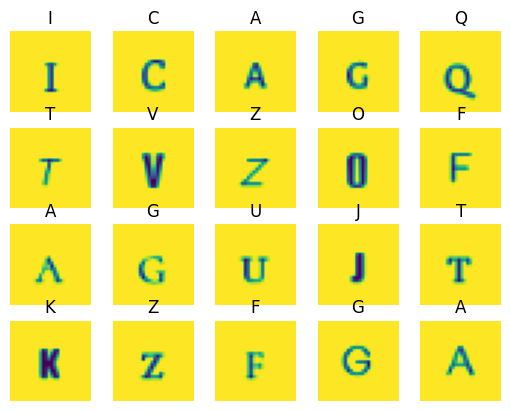

In [423]:
for i in range(20):
    plt.subplot(4,5,i+1) 
    plt.axis('off')
    plt.imshow(x[i])
    plt.title(y[i])

In [424]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [425]:
def build_generator(latent_dim):
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [426]:
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))


    return model

tf.Tensor([[0.00213041]], shape=(1, 1), dtype=float32)


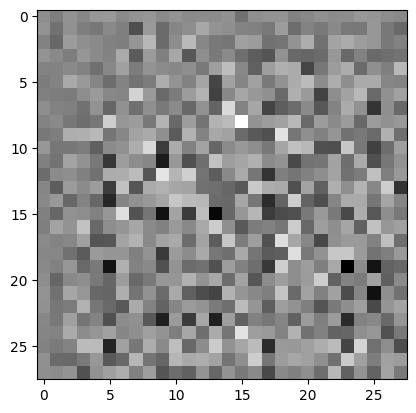

In [427]:
generator = build_generator(100)

noise = tf.random.normal([1, 100]) 
generated_image = generator(noise, training=False)
discriminator = build_discriminator()
decision = discriminator(generated_image)
print (decision)


plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [428]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [429]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [430]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [431]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [432]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [433]:

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [434]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      train_step(image_batch)
    display.clear_output(wait=True)
    generate_and_save_images(generator,epoch + 1,seed)
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)


In [435]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4, 4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.show()


In [436]:

EPOCHS = 10000
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [437]:
BUFFER_SIZE=520 
BATCH_SIZE=32

In [438]:
train_dataset = tf.data.Dataset.from_tensor_slices(x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [439]:
train_dataset = tf.data.Dataset.from_tensor_slices(x)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


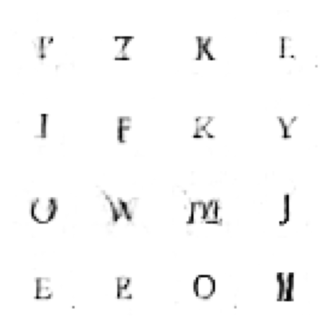

Time for epoch 7156 is 1.2381713390350342 sec


KeyboardInterrupt: 

In [440]:
train(train_dataset, EPOCHS)